# Phần 1 : Cấu trúc thay đổi ANN

In [7]:
# Cài đặt thư viện
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Tạo dữ liệu ngẫu nhiên
np.random.seed(0)
n_samples = 1000
X = np.random.randn(n_samples, 2)
y = (X[:, 0]**2 + X[:, 1]**2 > 1).astype(float)  # Phân loại dạng vòng tròn

In [8]:
# Chia tập dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuyển sang tensor PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [9]:
# Mô hình 1: 1 lớp ẩn với 8 nút
class ANN_8(nn.Module):
    def __init__(self):
        super(ANN_8, self).__init__()
        self.fc1 = nn.Linear(2, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [10]:
# Mô hình 2: 2 lớp ẩn (8 nút, 6 nút)
class ANN_8_6(nn.Module):
    def __init__(self):
        super(ANN_8_6, self).__init__()
        self.fc1 = nn.Linear(2, 8)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(8, 6)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(6, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [ ]:
# Hàm huấn luyện mô hình
def train_model(model, X_train, y_train, X_test, y_test, epochs=100):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        y_pred_test = (y_pred_test >= 0.5).float()
        accuracy = (y_pred_test == y_test).float().mean()
    
    return loss.item(), accuracy.item()

In [12]:
# Khởi tạo và huấn luyện mô hình
model_8 = ANN_8()
loss_8, acc_8 = train_model(model_8, X_train, y_train, X_test, y_test)

model_8_6 = ANN_8_6()
loss_8_6, acc_8_6 = train_model(model_8_6, X_train, y_train, X_test, y_test)

# In kết quả
print(f"Mô hình 8 nút: Loss = {loss_8:.4f}, Accuracy = {acc_8 * 100:.2f}%")
print(f"Mô hình 8+6 nút: Loss = {loss_8_6:.4f}, Accuracy = {acc_8_6 * 100:.2f}%")


Mô hình 8 nút: Loss = 0.3474, Accuracy = 91.00%
Mô hình 8+6 nút: Loss = 0.2138, Accuracy = 96.50%


So sánh 3 mô hình:

Mất mát: khi tăng số nút từ 4 lên 8 rồi 8+6 nút ẩn thì Loss giảm dần 0.4352 , 0.3474, 0.2138 . Cho thấy mô hình càng phức tạp thì nó càng học được nhiều đặc trưng tốt hơn.

Đô chính xác: Cũng tăng dần 84% của 4 nút , 91% của 8 nút và 96,5% của 8+6 nút. Việc tăng số nút và thêm một lớp ẩn giúp mô hình hoạt động chính xác hơn.

# Phần 2: THử nghiệm hàm mất mất và tôi ưu hoá

In [13]:
# Mô hình 2-4-1 với BCEWithLogitsLoss
class ANN_4_Logits(nn.Module):
    def __init__(self):
        super(ANN_4_Logits, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(4, 1)  # Không có Sigmoid
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)  # BCEWithLogitsLoss sẽ xử lý Sigmoid
        return x


In [14]:
# Mô hình 2-4-1 với SGD
class ANN_4_SGD(nn.Module):
    def __init__(self):
        super(ANN_4_SGD, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [34]:
# Hàm huấn luyện mô hình
def train_model(model, X_train, y_train, X_test, y_test, loss_fn, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train).squeeze()
        loss = loss_fn(y_pred, y_train.squeeze())  # Giúp kích thước phù hợp
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test).squeeze()
        y_pred_test = (y_pred_test >= 0.5).float()
        accuracy = (y_pred_test == y_test).float().mean()
    
    return loss.item(), accuracy.item()

In [45]:
# Khởi tạo mô hình và huấn luyện
model_4_logits = ANN_4_Logits()
criterion_logits = nn.BCEWithLogitsLoss()
optimizer_logits = optim.Adam(model_4_logits.parameters(), lr=0.01)
loss_4_logits, acc_4_logits = train_model(model_4_logits, X_train, y_train, X_test, y_test, criterion_logits, optimizer_logits)

model_4_sgd = ANN_4_SGD()
criterion_sgd = nn.BCELoss()
optimizer_sgd = optim.SGD(model_4_sgd.parameters(), lr=0.01)
loss_4_sgd, acc_4_sgd = train_model(model_4_sgd, X_train, y_train, X_test, y_test, criterion_sgd, optimizer_sgd)

# In kết quả
print(f"Mô hình 4 nút với BCEWithLogitsLoss: Loss = {loss_4_logits:.4f}, Accuracy = {acc_4_logits * 100:.2f}%")
print(f"Mô hình 4 nút với SGD: Loss = {loss_4_sgd:.4f}, Accuracy = {acc_4_sgd * 100:.2f}%")


Mô hình 4 nút với BCEWithLogitsLoss: Loss = 0.3931, Accuracy = 54.46%
Mô hình 4 nút với SGD: Loss = 0.6872, Accuracy = 66.50%


So sánh kết quả:

- BCEWithLogitsLoss so với BCELoss: Loss giảm nhẹ nhưng độ chính xác giảm mạnh từ 84% xuống 54.46%. BCEWithLogitsLoss làm việc trực tiếp với logits nên giá trị đầu ra chênh lệch lớn hơn so với BCELoss

- SGD so với Adam: Loss của SGD cao hơn đáng kể nhưng độ chính xác của SGD thấp hơn Adam. Do SGD cập nhật trọng số từng bước nhỏ , không có adaptive learning rate như Adam.

# Phần 3: Phân tích kết quả

In [79]:
# Định nghĩa các mô hình ANN
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # Thêm Sigmoid
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)  # Áp dụng Sigmoid trước khi trả về
        return x

In [80]:
# Hàm huấn luyện mô hình, lưu lại giá trị mất mát
def train_model(model, X_train, y_train, loss_fn, optimizer, epochs=100):
    loss_values = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())
    return loss_values

In [82]:
# Khởi tạo và huấn luyện 3 mô hình
loss_fn = nn.BCELoss()  # Sửa thành BCELoss

model_2_4_1 = ANN(2, 4, 1)
optimizer_2_4_1 = optim.Adam(model_2_4_1.parameters(), lr=0.01)
loss_2_4_1 = train_model(model_2_4_1, X_train, y_train, loss_fn, optimizer_2_4_1)

model_2_8_1 = ANN(2, 8, 1)
optimizer_2_8_1 = optim.Adam(model_2_8_1.parameters(), lr=0.01)
loss_2_8_1 = train_model(model_2_8_1, X_train, y_train, loss_fn, optimizer_2_8_1)

model_2_4_1_sgd = ANN(2, 4, 1)
optimizer_2_4_1_sgd = optim.SGD(model_2_4_1_sgd.parameters(), lr=0.01)
loss_2_4_1_sgd = train_model(model_2_4_1_sgd, X_train, y_train, loss_fn, optimizer_2_4_1_sgd)


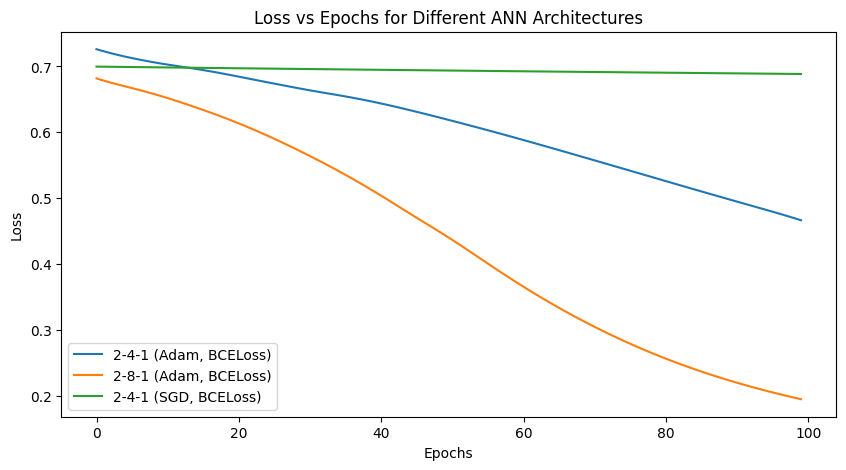

In [83]:
# Vẽ đồ thị mất mát
plt.figure(figsize=(10, 5))
plt.plot(loss_2_4_1, label='2-4-1 (Adam, BCELoss)')
plt.plot(loss_2_8_1, label='2-8-1 (Adam, BCELoss)')
plt.plot(loss_2_4_1_sgd, label='2-4-1 (SGD, BCELoss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs for Different ANN Architectures')
plt.legend()
plt.show()

Mất mát giảm nhanh nhất ở mô hình 2-8-1 và giảm chậm nhất là mô hình 2-4-1 ( SGD, BCELoss)

Không có trường hợp nào mất mát giao động mạnh do learning rate không quá lớn, số lượng epoch đủ lớn.